## SKU110K Dataset to YOLOv5 Format


> `Date: 02/01/2022`
<br/>
> `Author: @datasith`
<br/>
> `Last Modified:`
<br/>
> `@datasith - 05/11/2022`
<br/>
> `License: https://github.com/datasith/datasith/blob/main/licenses/LICENSE.nsfw`


#### Download and extract the SKU110K dataset

This step will vary by Users' preference. If nothing else, it serves to keep track of the URL where to find the dataset

In [10]:
# sku_dataset_folder  = # 'Path to directory where the images were downloaded'
sku_dataset_folder  = '/Users/datasith/Downloads/'

# !wget http://trax-geometry.s3.amazonaws.com/cvpr_challenge/SKU110K_fixed.tar.gz -P "$sku_dataset_folder"
# !curl http://trax-geometry.s3.amazonaws.com/cvpr_challenge/SKU110K_fixed.tar.gz --create-dirs -O --output-dir "$sku_dataset_folder"

In [2]:
!tar -xf "$sku_dataset_folder"/SKU110K_fixed.tar.gz -C "$sku_dataset_folder" > /dev/null

#### Import necessary libraries

In [8]:
import cv2
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import shutil
from pathlib import Path

#### Set up the dataset's local path

In [11]:
sku_dataset_dirname = 'SKU110K_fixed'
path_images         = Path(sku_dataset_folder) / sku_dataset_dirname / 'images'
path_annotations    = Path(sku_dataset_folder) / sku_dataset_dirname / 'annotations'

In [13]:
# Sanity check
# !ls $path_images

#### Re-organize files into test, train, and validation 

In [18]:
prefix_to_channel = {
    "train": "train",
    "val": "validation",
    "test": "test",
}

assert path_images.exists(), f"{path_images} not found"

for channel_name in prefix_to_channel.values():
    if not (path_images.parent / channel_name).exists():
        (path_images.parent / channel_name).mkdir()

for path_img in path_images.iterdir():
    for prefix in prefix_to_channel:
        if path_img.name.startswith(prefix):
            path_img.replace(
                path_images.parent / prefix_to_channel[prefix] / path_img.name
            )

#### Remove corrupted files

In [5]:
# Revised list (54 images) courtesy of ankandrew on GitHub:
# https://github.com/eg4000/SKU110K_CVPR19/issues/99#issuecomment-988886374
CORRUPTED_IMAGES = {
    "train": (
              "train_1239.jpg",
              "train_2376.jpg",
              "train_2903.jpg",
              "train_2986.jpg",
              "train_305.jpg",
              "train_3240.jpg",
              "train_340.jpg",
              "train_3556.jpg",
              "train_3560.jpg",
              "train_3832.jpg",
              "train_38.jpg",
              "train_4222.jpg",
              "train_5007.jpg",
              "train_5137.jpg",
              "train_5143.jpg",
              "train_5762.jpg",
              "train_5822.jpg",
              "train_6052.jpg",
              "train_6090.jpg",
              "train_6138.jpg",
              "train_6409.jpg",
              "train_6722.jpg",
              "train_6788.jpg",
              "train_737.jpg",
              "train_7576.jpg",
              "train_7622.jpg",
              "train_775.jpg",
              "train_7883.jpg",
              "train_789.jpg",
              "train_8020.jpg",
              "train_8146.jpg",
              "train_882.jpg",
              "train_903.jpg",
              "train_924.jpg"
             ),
    "validation": (
              "val_147.jpg",
              "val_286.jpg",
              "val_296.jpg",
              "val_386.jpg"
             ),
    "test": (
              "test_132.jpg",
              "test_1346.jpg",
              "test_184.jpg",
              "test_1929.jpg",
              "test_2028.jpg",
              "test_22.jpg",
              "test_2321.jpg",
              "test_232.jpg",
              "test_2613.jpg",
              "test_2643.jpg",
              "test_274.jpg",
              "test_2878.jpg",
              "test_521.jpg",
              "test_853.jpg",
              "test_910.jpg",
              "test_923.jpg"
             ),             
}

In [15]:
for channel_name in prefix_to_channel.values():
    for img_name in CORRUPTED_IMAGES[channel_name]:
        try:
            (path_images.parent / channel_name / img_name).unlink()
            print(f"{img_name} removed from channel {channel_name} ")
        except FileNotFoundError:
            print(f"{img_name} not in channel {channel_name}")

train_1239.jpg removed from channel train 
train_2376.jpg removed from channel train 
train_2903.jpg removed from channel train 
train_2986.jpg removed from channel train 
train_305.jpg removed from channel train 
train_3240.jpg removed from channel train 
train_340.jpg removed from channel train 
train_3556.jpg removed from channel train 
train_3560.jpg removed from channel train 
train_3832.jpg removed from channel train 
train_38.jpg removed from channel train 
train_4222.jpg not in channel train
train_5007.jpg removed from channel train 
train_5137.jpg removed from channel train 
train_5143.jpg removed from channel train 
train_5762.jpg removed from channel train 
train_5822.jpg not in channel train
train_6052.jpg removed from channel train 
train_6090.jpg removed from channel train 
train_6138.jpg removed from channel train 
train_6409.jpg removed from channel train 
train_6722.jpg removed from channel train 
train_6788.jpg removed from channel train 
train_737.jpg removed from ch

In [17]:
# Expected output:
# Number of train images = 8185
# Number of validation images = 584
# Number of test images = 2919
for channel_name in prefix_to_channel.values():
    print(
        f"Number of {channel_name} images = {sum(1 for x in (path_images.parent / channel_name).glob('*.jpg'))}"
    )

Number of train images = 8185
Number of validation images = 584
Number of test images = 2919


In [11]:
os.rmdir(path_images)

#### Reformat label (annotations) data

In [19]:
yolov5_dataset_folder = os.getcwd()
yolov5_sku_dataset_dirname = 'SKU110K_fixed'
local_path_annotations = Path(yolov5_dataset_folder) / yolov5_sku_dataset_dirname / 'labels'
local_path_images = Path(yolov5_dataset_folder) / yolov5_sku_dataset_dirname / 'images'

In [20]:
!mkdir -p $local_path_annotations $local_path_images

The original format of the `SKU110K` dataset is:

`'image', 'x1', 'y1', 'x2', 'y2', 'class', 'image_width', 'image_height'`

We need to convert it to `YOLO` format, which is:

`'class', 'x1', 'y1', 'x2', 'y2'`

We also need to normalize the bounding box coordinates as expected by the model

In [22]:
names = 'image', 'x1', 'y1', 'x2', 'y2', 'class', 'image_width', 'image_height'
annotation_files =  path_annotations.glob('*.csv')

import sys

for file in annotation_files:
    print(file)
    data = pd.read_csv(file, names=names)  # annotations
    prefix = file.name.split('_')[-1].replace('.csv','')
    out_labels_dir = local_path_annotations / prefix
    out_images_dir = local_path_images / prefix

    isExist = os.path.exists(out_labels_dir)
    if not isExist:
        os.mkdir(out_labels_dir)

    isExist = os.path.exists(out_images_dir)
    if not isExist:
        os.mkdir(out_images_dir)
        
    for filename_img in data['image'].unique():
        # Get all bounding boxes for this image
        mask_filename_img = data['image'] == filename_img
        data_img = data[mask_filename_img].copy().reset_index()

        # Reformat each bounding box and add it to output file
        # YOLO format is normalized (img_width, img_height) = (1, 1)
        # NOTE: there are several erroneous annotations. Please see: 
        # https://github.com/eg4000/SKU110K_CVPR19/issues
        # for details.
        # 
        # I noticed a quite a few bounding boxes exceeding the boundaries
        # of the image. Ideally I should do something more sophisticated, 
        # but per eye inspection, the differences were "negligible". In 
        # order to be able to use the infringing image/annotation pairs 
        # when training a YOLOv5 model (which checks the normalization 
        # range to be [0,1]), I'm simply clipping to an upper bound of 1.
        width = data_img.image_width[0]
        height = data_img.image_height[0]
        data_img['x1'] = data_img['x1'] / width
        data_img['x1'] = data_img['x1'].where(data_img['x1'] <= 1., 1.) 
        data_img['y1'] = data_img['y1'] / height
        data_img['y1'] = data_img['y1'].where(data_img['y1'] <= 1., 1.) 
        data_img['x2'] = data_img['x2'] / width
        data_img['x2'] = data_img['x2'].where(data_img['x2'] <= 1., 1.) 
        data_img['y2'] = data_img['y2'] / height
        data_img['y2'] = data_img['y2'].where(data_img['y2'] <= 1., 1.) 
        data_img['class'] = 0
        
        data_img = data_img[['class','x1','y1','x2','y2']]

        # Set up the necessary paths
        filename_label = filename_img.replace('jpg','txt')
        out_labels_file = out_labels_dir / filename_label
        in_images_file = path_images.parent / prefix_to_channel[prefix] / filename_img
        out_images_file = out_images_dir / filename_img

        try:
            _ = shutil.copy2(in_images_file, out_images_file)
        except:
            # Exceptions are due to image file not existing for the corresponding label
            # raise NameError('check the image file name')
            print(f'check the image file name {filename_img}') 
            continue

        # If the image file is found and copied, it's safe to generate the corresponding label file
        data_img.to_csv(out_labels_file , sep=' ', header=False, index=False)

/Users/datasith/Downloads/SKU110K_fixed/annotations/annotations_test.csv
check the image file name test_132.jpg
check the image file name test_1346.jpg
check the image file name test_184.jpg
check the image file name test_1929.jpg
check the image file name test_2028.jpg
check the image file name test_22.jpg
check the image file name test_232.jpg
check the image file name test_2321.jpg
check the image file name test_2613.jpg
check the image file name test_2643.jpg
check the image file name test_274.jpg
check the image file name test_2878.jpg
check the image file name test_2924.jpg
check the image file name test_521.jpg
check the image file name test_853.jpg
check the image file name test_910.jpg
check the image file name test_923.jpg
/Users/datasith/Downloads/SKU110K_fixed/annotations/annotations_val.csv
check the image file name val_147.jpg
check the image file name val_286.jpg
check the image file name val_296.jpg
check the image file name val_386.jpg
/Users/datasith/Downloads/SKU110K

#### Visualize saved annotations

/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/images/train/train_6164.jpg
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/labels/train/train_6164.txt
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/images/train/train_4081.jpg
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/labels/train/train_4081.txt
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/images/train/train_7548.jpg
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/labels/train/train_7548.txt
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/images/val/val_121.jpg
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/labels/val/val_121.txt
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/images/val/val_403.jpg
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/labels/val/val_403.txt
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/images/val/val_445.jpg
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/labels/val/val_445.txt
/Users/datasith/Work/ds-datasets-s

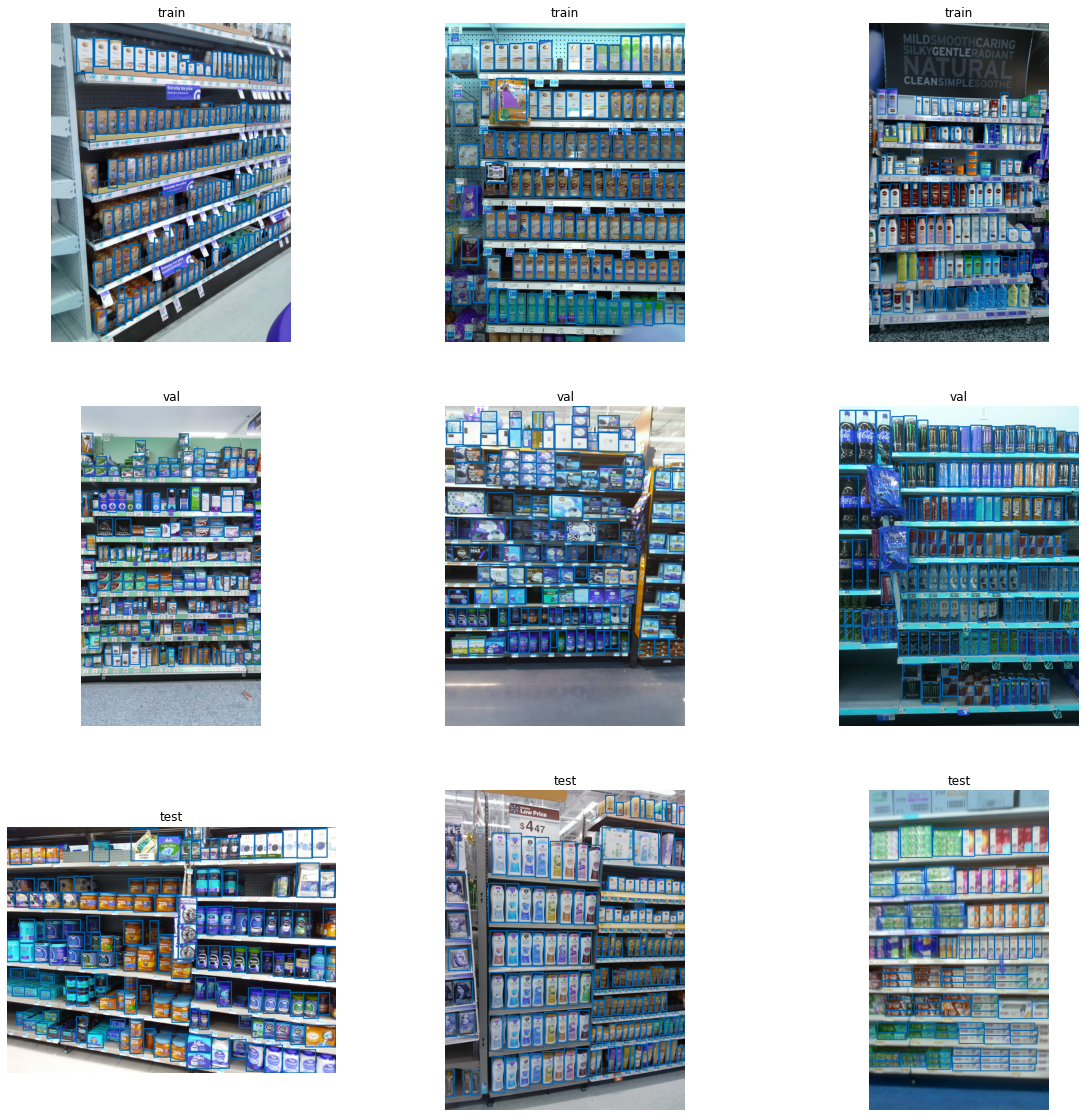

In [23]:
counter = 1
plt.figure(figsize=(20, 20), facecolor='white')

for prefix in prefix_to_channel:
    _path = local_path_images / prefix / '*'
    local_files_images = glob.glob(_path.as_posix())
    for idx in random.sample(range(0, len(local_files_images)), 3):
        filename_image = local_files_images[idx]
        filename_label = filename_image.replace('images','labels').replace('jpg','txt')
        data = pd.read_csv(filename_label, header=None, delimiter=' ')
        
        print(filename_image)
        print(filename_label)
        im = cv2.imread(filename_image)
        im_size = im.shape[:2]
        for _, bbox in data.iterrows():
            cls, xmin, ymin, xmax, ymax = bbox
            xmin = xmin*im_size[1]
            ymin = ymin*im_size[0]
            xmax = xmax*im_size[1]
            ymax = ymax*im_size[0]

            start_point = (int(xmin), int(ymin))
            end_point = (int(xmax), int(ymax))
            color = (0, 100, 175)
            thickness = 10

            im = cv2.rectangle(im, start_point, end_point, color, thickness)

        ax = plt.subplot(3, 3, counter)
        plt.title(prefix)
        plt.axis("off")
        plt.imshow(im)
        counter += 1